In [39]:
import numpy as np

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
import tensorflow as tf

from utils import NOMA, Rayleigh_canal
import matplotlib.pyplot as plt
from termcolor import colored
from scipy.special import erfc

In [23]:
tx_params = {
    "nUsers" : 3,
    "powerAllocation" : np.zeros(3),
    "nCode" : 120,
    "kCode" : 60,
    "codingRate": 1/2,
}


In [24]:
data = np.zeros((tx_params["nUsers"], tx_params["nCode"]))

data_out = NOMA(data, tx_params)

In [25]:
nmodbits = 2
binary_source = sionna.utils.BinarySource()
constellation = sionna.mapping.Constellation("qam", nmodbits)
encoder = sionna.fec.conv.ConvEncoder(rate=tx_params["codingRate"])
mapper = sionna.mapping.Mapper(constellation=constellation)
channel = sionna.channel.AWGN()
demapper = sionna.mapping.Demapper("app","qam", nmodbits, hard_out=True,  dtype=tf.complex128)
decoder = sionna.fec.conv.ViterbiDecoder(encoder=encoder, rate=tx_params["codingRate"],  constraint_length=3)

In [56]:

ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq = 1000
alpha = 0

BER_coded = np.zeros(len(ebn0))
BER_uncoded = np.zeros(len(ebn0))

for ii in range(len(snr_db)) :

  BER_coded_ii = np.zeros(nb_seq)
  BER_uncoded_ii = np.zeros(nb_seq)

  var_noise = 1/(10**(0.1*snr_db[ii]))

  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 15 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    #polynomial = np.array([1, 3, 3, -1*Ptot/var_noise])
    polynomial = np.array([1, 2, 1, -1*Ptot])
    roots = np.roots(polynomial) # roots of polynomial
    x = roots[np.isreal(roots)][-1] # keep only real root

    #Evaluate the root 
    #print(polynomial[0]*x**3 + polynomial[1]*x**2 + polynomial[2]*x + polynomial[3]	)

    if(len(roots[np.isreal(roots)])>1) : 
      print("More than 2 roots found in polynomial")

    # P1 = x
    # P2 = ((x**2) + x)
    # P3 = ((x**3) + 2*(x**2) + x)

    # P1 = 10*(var_noise)
    # P2 = 10*(P1 + var_noise)
    # P3 = 10*(P1 + P2 + var_noise)

    # factor = Ptot/(P1+P2+P3)
    # P1 *= factor
    # P2 *= factor
    # P3 *= factor

    P3 = x**3 + x**2
    P2 = x**2 
    P1 = x

    tx_params["powerAllocation"] = np.array([P3, P2, P1])
    if jj==1 : 
    #  fig = plt.figure()
    #  x = np.linspace(-10, 10, 100)
    #  plt.plot(x, polynomial[0] + polynomial[1]*x + polynomial[2]*(x**2) + polynomial[3]*(x**3))
    #  plt.grid()
    #  plt.show()
     print("Noise variance: ", var_noise)
     #print(roots)
     print("Natural scale: ", P1/var_noise, P2/(P1 + var_noise), P3/(P2 + P1 + var_noise))
     print("Log scale: ", 10*np.log10(P1/var_noise), 10*np.log10(P2/(P1 + var_noise)), 10*np.log10(P3/(P2 + P1 + var_noise)))
     print("Sum of powers: ", P1+P2+P3)


    data = np.zeros((tx_params["nUsers"], tx_params["kCode"])) # nCode noramlement (à changer après)
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]])
    #c = encoder(b)
    c= b 
    x = mapper(c)
    data = x.numpy()

    data_out = NOMA(data, tx_params)
    
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))

    y_canal = h*data_out+n
    #y_canal = channel([data_out, var_noise])
    #y_canal = data_out + n

    # Reception 
    #y_canal = y_canal.reshape(1, len(y_canal))
    y_received = y_canal/h
    #y_received = y_canal
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["kCode"])) # nCode noramlement (à changer après)
    # SIC 
    for idx_user in range(tx_params["nUsers"]):

      y = demapper([tf.convert_to_tensor(y_received), var_noise])

      y_demapped[idx_user, :] = y.numpy()

      #y_user = decoder(tf.convert_to_tensor(y.numpy().reshape((1, len(y)))))
      y_user = tf.convert_to_tensor(y.numpy().reshape((1, len(y))))

      y_decoded[idx_user, :] = y_user.numpy()

      y_received = y_received - mapper(y_user).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.float32)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    BER_coded_ii[jj] = ber_coded.numpy()
    BER_uncoded_ii[jj] = ber_uncoded.numpy()
  
  BER_coded[ii] = np.mean(BER_coded_ii)
  BER_uncoded[ii] = np.mean(BER_uncoded_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded[ii]) + ", BER coded = " + str(BER_coded[ii]))
  

Noise variance:  1.0
Natural scale:  (2.533185805914182+0j) (1.8162164912311287+0j) (2.2785997977306898+0j)
Log scale:  (4.0366704589940845+0j) (2.591676147485214+0j) (3.5766805449169423+0j)
Sum of powers:  (31.62277660168376+0j)
Eb/N0 = 0dB, BER uncoded = 0.13368888888888886, BER coded = 0.13368888888888886
Noise variance:  0.7943282347242815
Natural scale:  (3.189091983861651+0j) (1.9284758077395887+0j) (2.32669272286517+0j)
Log scale:  (5.036670458994086+0j) (2.8521419511748602+0j) (3.667390315137562+0j)
Sum of powers:  (31.62277660168376+0j)
Eb/N0 = 1dB, BER uncoded = 0.1176888888888889, BER coded = 0.1176888888888889
Noise variance:  0.6309573444801932
Natural scale:  (4.0148289390325065+0j) (2.0280467798953+0j) (2.366365719324784+0j)
Log scale:  (6.036670458994085+0j) (3.070779684207061+0j) (3.740818652329729+0j)
Sum of powers:  (31.62277660168376+0j)
Eb/N0 = 2dB, BER uncoded = 0.10583333333333335, BER coded = 0.10583333333333335
Noise variance:  0.5011872336272722
Natural scale:

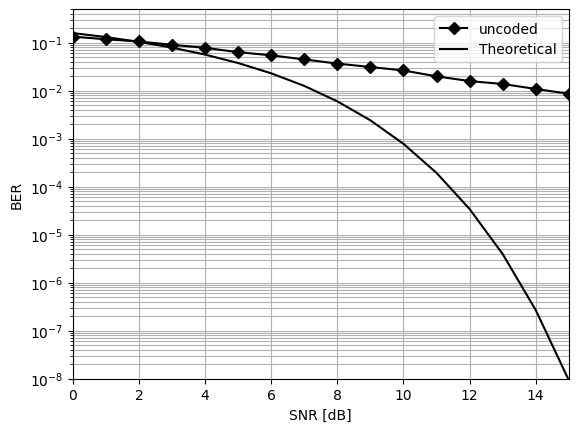

In [57]:
# Plot

plt.figure()
#plt.semilogy(snr_db, BER_coded, "o-", label="coded", color="black")
plt.semilogy(snr_db, BER_uncoded, "D-", label="uncoded", color="black")
ber = (1/2)*erfc(np.sqrt(10**(0.1*snr_db)/2))
plt.plot(ebn0, ber, label="Theoretical", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.xlim([0, 15])
plt.ylim([10**(-8), 0.5])
plt.show()